# 1. Building a data pipeline

In [1]:
# Import the required libraries

import warnings 
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import cv2 
import imghdr
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras import callbacks
from keras.metrics import Precision, Recall
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [67]:
# # created a directory to save input dataset
# os.mkdir('Data')

Image dataset categories and count of files in each: 
[('cardboard', 403), ('food', 735), ('glass', 501), ('metal', 409)]


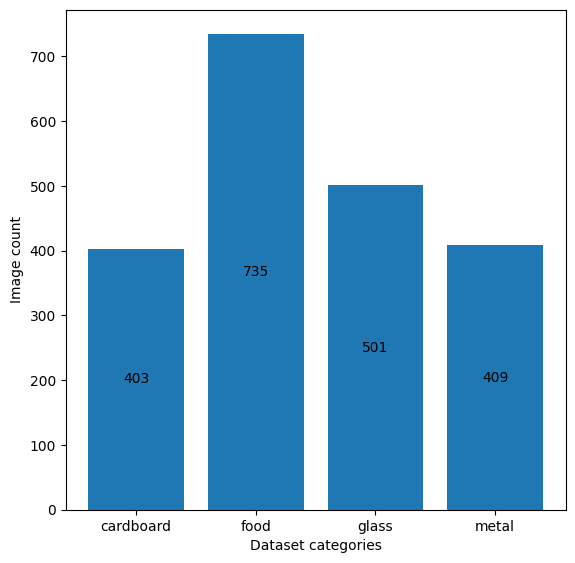

In [68]:
# Listing down the images dataset available along with their content size and visualization
print('Image dataset categories and count of files in each: ')
print([(i, len(os.listdir(os.path.join('Data', i)))) for i in os.listdir('Data')]) 

fig = plt.figure(figsize=(5,5))
ax = fig.add_axes([0,0,1,1])
dic = {i: len(os.listdir(os.path.join('Data', i))) for i in os.listdir('Data')}

categories = dic.keys()
imgcount = dic.values()
p1 = ax.bar(categories, imgcount)
ax.set_ylabel("Image count")
ax.set_xlabel("Dataset categories")
ax.bar_label(p1, label_type='center')
plt.show()

AxesImage(size=(384, 512))


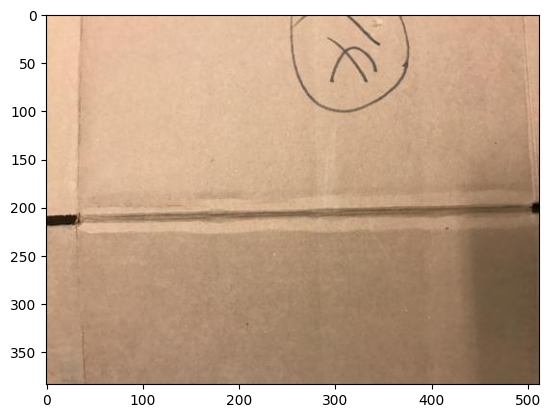

AxesImage(size=(1024, 1024))


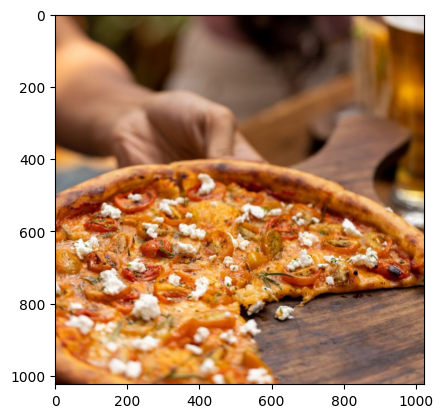

AxesImage(size=(384, 512))


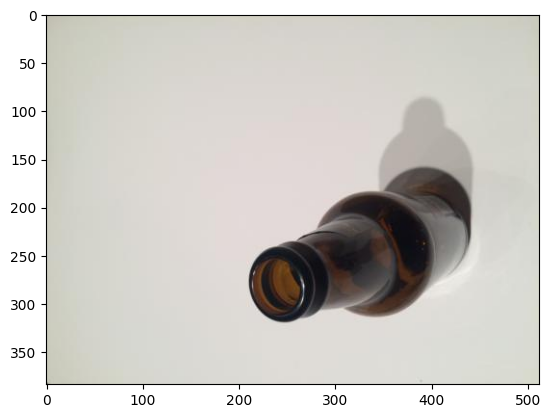

AxesImage(size=(384, 512))


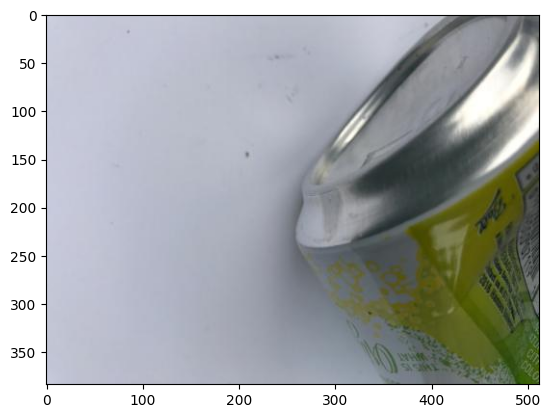

In [69]:
# Check image from each class along with their dimensions

for folder in os.listdir('Data'):
    img = os.listdir(os.path.join('Data', folder))[0]
    image_path = os.path.join('Data', folder, img)
    image = cv2.imread(image_path)
    # print(image)
    print(plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))) # COLOR_BGR2RGB is to get the original color of the image
    plt.show()

In [70]:
# Data cleaning ~ to avoid those images that might not open in python due to corrupted, mislabelled, or incorrect extension applied:
# 1. remove those images with size lesser than 11 KB i.e. 11,000 bytes (only from food dataset)

low_quality_images = [os.path.join('Data', 'food', i) for i in os.listdir(os.path.join('Data', 'food')) 
                                if os.path.getsize(os.path.join('Data', 'food', i)) < 11000]

# 2. remove all the dodgy images
# create a list of extensions
image_exts = ['jpeg', 'png', 'jpg', 'bmp']
error_exts = {}

for folder in os.listdir('Data'):
    class_folder = os.path.join('Data', folder)

    # check all dodgy images by verifying their extensions
    for img in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img)
        try:
            # check the extension
            ext = imghdr.what(img_path)
            if ext not in image_exts:
                try: 
                    error_exts[ext].append(img_path)
                except:
                    error_exts[ext] = img_path
                
        except:
            print('Issue with image {}'.format(img_path))


OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

AxesImage(size=(100, 100))


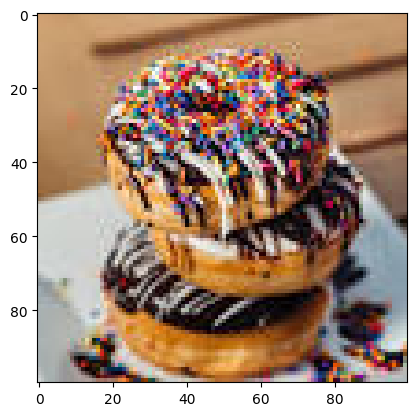

AxesImage(size=(100, 100))


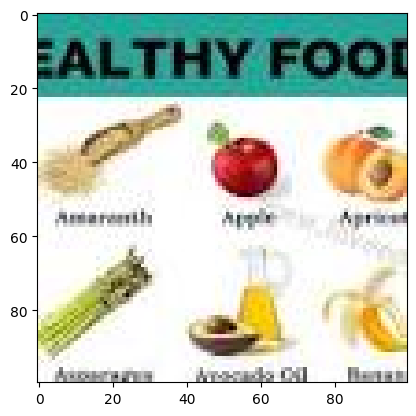

AxesImage(size=(225, 225))


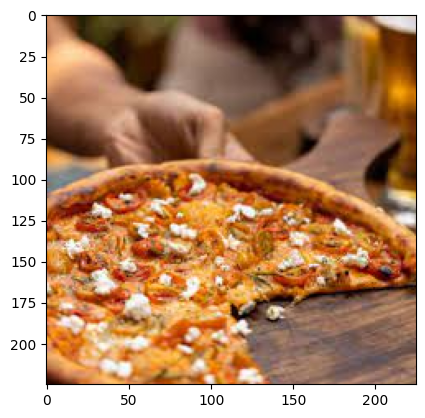

In [71]:
# Visualization of images with size less than 11 kb
for i in range(4):
    image = cv2.imread(low_quality_images[i])
    try:
        print(plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))) # COLOR_BGR2RGB is to get the original color of the image
        plt.show()
    except Exception as e:
        print(e)

In [72]:
# the extensions which cannot be open
error_exts

{None: 'Data\\food\\vector9.svg',
 'webp': 'Data\\food\\d19a31d42d5913ff129cafd7cec772f81639737697.png'}

In [73]:
# remove all the low quality images and incorrect extensions

for items in low_quality_images:
    try: 
        os.remove(items)
    except: 
        print("Already removed file {}".format(items))
for items in error_exts.values():
    try: 
        os.remove(items)
    except: 
        print("Already removed file {}".format(items))

Already removed file Data\food\vector9.svg


After cleaning, image dataset categories and count of files in each: 
[('cardboard', 403), ('food', 422), ('glass', 501), ('metal', 409)]


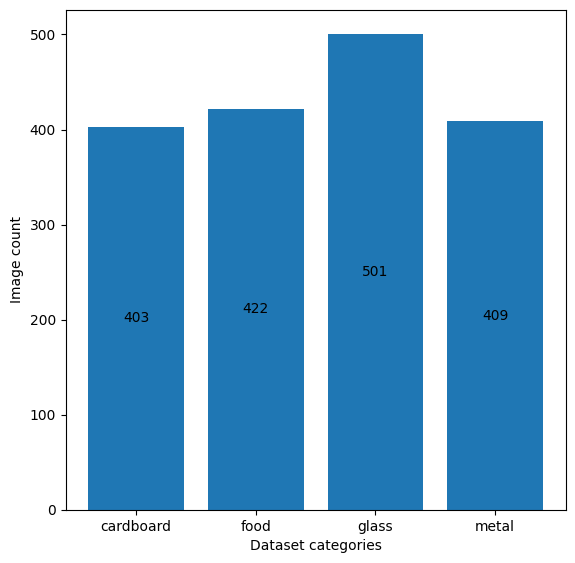

In [74]:
# Listing down the images dataset available along with their content size, after cleaning.
print('After cleaning, image dataset categories and count of files in each: ')
print([(i, len(os.listdir(os.path.join('Data', i)))) for i in os.listdir('Data')])

fig = plt.figure(figsize=(5,5))
ax = fig.add_axes([0,0,1,1])
dic = {i: len(os.listdir(os.path.join('Data', i))) for i in os.listdir('Data')}
categories = dic.keys()
imgcount = dic.values()
p1 = ax.bar(categories, imgcount)
ax.set_ylabel("Image count")
ax.set_xlabel("Dataset categories")
ax.bar_label(p1, label_type='center')
plt.show()

In [75]:
# After cleaning, lets load the dataset into the pipeline for processing 
data = tf.keras.utils.image_dataset_from_directory('Data')

# Here we have loaded the images into the data pipeline for batches production
print(data)

# to enable iteration and access to each batch
data_iterator = data.as_numpy_iterator()

Found 1735 files belonging to 4 classes.
<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [76]:
batch = data_iterator.next()
print('Batch size: {}'.format(len(batch))) # comes out as 2, as tuple of (list of size, list of label)

# batch[0] - contains numpy array representation of each image stored in the batch
# batch[1] - contains class id for each image, say, 0, 1, and so on, depends on the count of classes
print('Contains numpy representation for {} images'.format(len(batch[0])))
print('Contains class ids for {} images'.format(len(batch[1])))

Batch size: 2
Contains numpy representation for 32 images
Contains class ids for 32 images


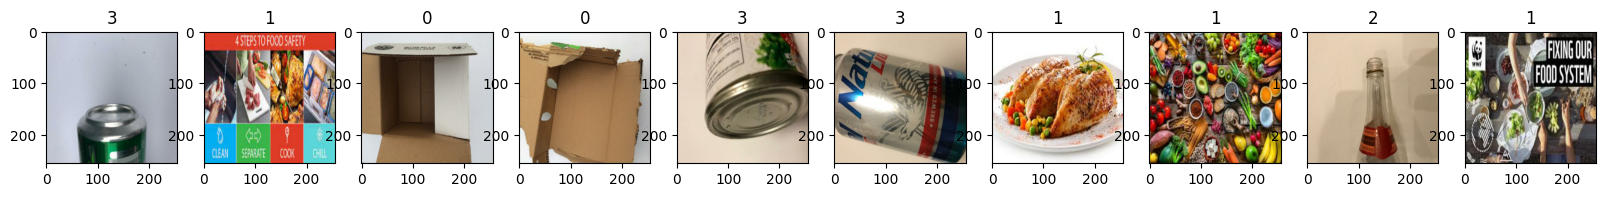

In [77]:
# Lets visualize one set of images from a single batch
fig, ax = plt.subplots(ncols= 10, figsize= (20,20))
for idx, img in enumerate(batch[0][:10]):
    ax[idx].imshow(img.astype(int))
    # set title for each image as the class id
    ax[idx].title.set_text(batch[1][idx])

plt.show()

In [78]:
# From above we can understand that the data pipeline has created the following labels,
classes = {0: 'Cardboard Waste (Biodegradable)', 1: 'Food Waste (Biodegradable)', 2: 'Glass Waste (Non-Biodegradable)', 3:'Metal Waste (Non-Biodegradable)'}
print("Ids for categories: {}".format(classes))

Ids for categories: {0: 'Cardboard Waste (Biodegradable)', 1: 'Food Waste (Biodegradable)', 2: 'Glass Waste (Non-Biodegradable)', 3: 'Metal Waste (Non-Biodegradable)'}


# 2. Preprocessing images for DL model

In [79]:
print("Size of batch first element: {}".format(batch[0].shape))
print("Minimum dimension of image: {}".format(batch[0].min()))
print("Maximum dimension of image: {}".format(batch[0].max()))

Size of batch first element: (32, 256, 256, 3)
Minimum dimension of image: 0.0
Maximum dimension of image: 255.0


Found 1735 files belonging to 4 classes.
Minimum dimension of image: 0.0
Maximum dimension of image: 1.0


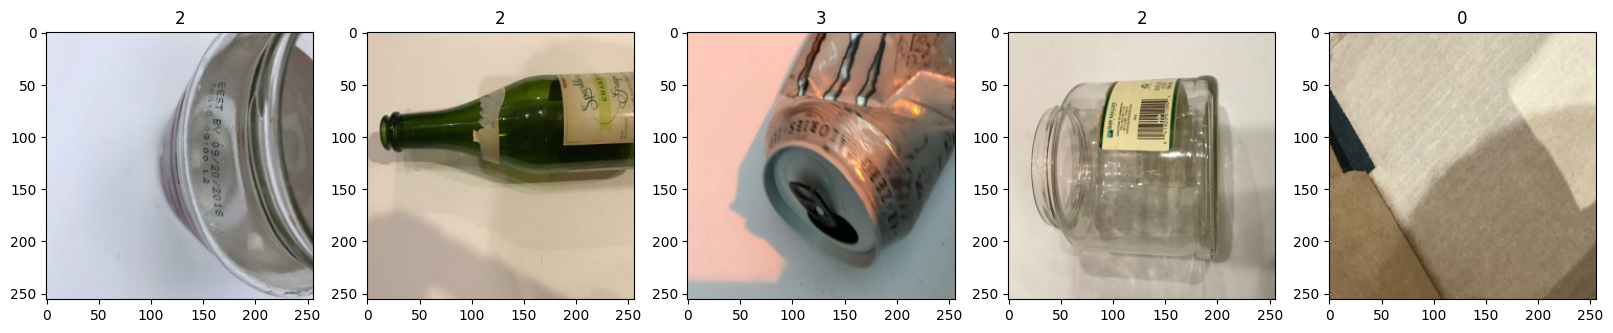

In [80]:
# Since the dimension of images in batch of 32 images is (256,256,3), we need to scale/normalize the dimensions between 0 and 1 (instead of 0 to 256).

data = tf.keras.utils.image_dataset_from_directory('Data')
data = data.map(lambda x,y: (x/255,y))

scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

print("Minimum dimension of image: {}".format(batch[0].min()))
print("Maximum dimension of image: {}".format(batch[0].max()))

# Visualize
fig, ax = plt.subplots(ncols=5, figsize= (20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img)
    ax[idx].set_title(batch[1][idx])
plt.show()

In [81]:
# Split the data into 3 partitions for model processing: 
# 1. 70% - training, 
# 2. 20% - validation, and,
# 3. 10% - testing
print("Total count of batches created: {}".format(len(data)))

train_size = int(len(data) * .7)
val_size = int(len(data) * .2)
test_size = int(len(data) * .1) + 1
print("Count of batches in training dataset: {}, validation dataset: {}, testing dataset: {}".format(train_size, val_size, test_size))

Total count of batches created: 55
Count of batches in training dataset: 38, validation dataset: 11, testing dataset: 6


In [82]:
# Created the dataset based on the batch size after shuffling the images

data = data.shuffle(buffer_size= 1735) # total images= 1735 files
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 3. Build a deep neural network classifier

In [83]:
# Building model object using Sequential 
model = tf.keras.models.Sequential()

# Adding layers along with activation function to include non-linear relation

# First convolutional layer
model.add(Conv2D(filters= 16, kernel_size= (3,3), strides= 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

# Second convolutional layer
model.add(Conv2D(filters= 32, kernel_size= (3,3), strides= 1, activation='relu'))
model.add(MaxPooling2D())

# Third layer
model.add(Conv2D(filters= 16, kernel_size= (3,3), strides= 1, activation='relu'))
model.add(MaxPooling2D())

# Flattening the data
model.add(Flatten())

# Hidden layer
model.add(Dense(units= 256, activation='relu'))

# Output layer
model.add(Dense(units= 4, activation='softmax'))

# Compile the model using loss and optimizer functions
model.compile(optimizer= 'adam', loss=keras.losses.SparseCategoricalCrossentropy(),
         metrics=['accuracy']
     )

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 30, 16)      

Epoch 1/10
38/38 [==============================] - 34s 824ms/step - loss: 1.0051 - accuracy: 0.5609 - val_loss: 0.6604 - val_accuracy: 0.7131
Epoch 2/10
38/38 [==============================] - 34s 799ms/step - loss: 0.6668 - accuracy: 0.7313 - val_loss: 0.5880 - val_accuracy: 0.7784
Epoch 3/10
38/38 [==============================] - 33s 787ms/step - loss: 0.5667 - accuracy: 0.7716 - val_loss: 0.5364 - val_accuracy: 0.7812
Epoch 4/10
38/38 [==============================] - 33s 792ms/step - loss: 0.5455 - accuracy: 0.7767 - val_loss: 0.5727 - val_accuracy: 0.7614
Epoch 5/10
38/38 [==============================] - 33s 796ms/step - loss: 0.4686 - accuracy: 0.8199 - val_loss: 0.3833 - val_accuracy: 0.8523
Epoch 6/10
38/38 [==============================] - 34s 817ms/step - loss: 0.4043 - accuracy: 0.8355 - val_loss: 0.4299 - val_accuracy: 0.8381
Epoch 7/10
38/38 [==============================] - 33s 803ms/step - loss: 0.3473 - accuracy: 0.8631 - val_loss: 0.3387 - val_accuracy: 0.8778

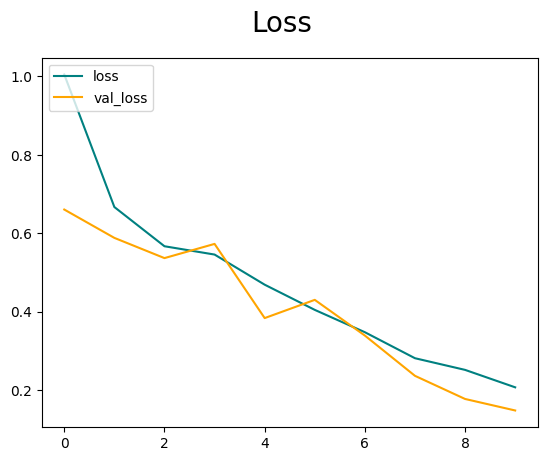

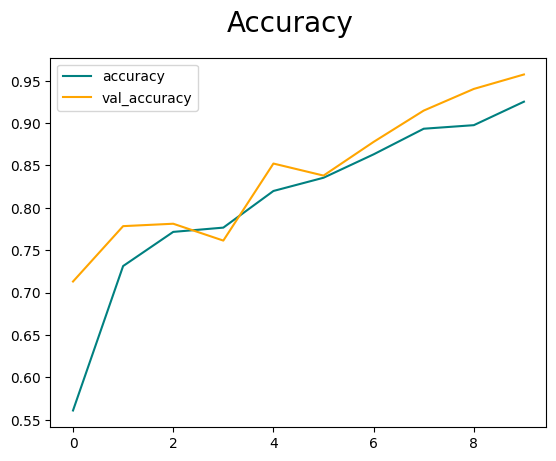

In [84]:
# Experimenting different epochs values to assess the accuarcy and loss based on the iterations
epoch_count = 10
history = model.fit(train, epochs= epoch_count, validation_data= val, shuffle= True)

# Loss visualization
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


# Accuracy visualization
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [85]:
# Now, instead of creating random inputs for epochs to get the best result, 
# we can use EarlyStopping and provide a larger upper limit for the same.

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True, verbose=1)

history = model.fit(train, 
                    epochs= 40, # this has been changed after multiple model run  
                    validation_data= val, 
                    callbacks =[earlystopping],
                    shuffle= True) 

Epoch 1/40
38/38 [==============================] - 34s 798ms/step - loss: 0.1936 - accuracy: 0.9320 - val_loss: 0.0977 - val_accuracy: 0.9773
Epoch 2/40
38/38 [==============================] - 34s 801ms/step - loss: 0.1329 - accuracy: 0.9580 - val_loss: 0.0970 - val_accuracy: 0.9659
Epoch 3/40
38/38 [==============================] - 34s 817ms/step - loss: 0.0971 - accuracy: 0.9647 - val_loss: 0.1141 - val_accuracy: 0.9517
Epoch 4/40
38/38 [==============================] - 35s 826ms/step - loss: 0.1189 - accuracy: 0.9605 - val_loss: 0.1468 - val_accuracy: 0.9602
Epoch 5/40
38/38 [==============================] - 34s 800ms/step - loss: 0.1393 - accuracy: 0.9454 - val_loss: 0.0710 - val_accuracy: 0.9830
Epoch 6/40
38/38 [==============================] - 33s 794ms/step - loss: 0.0726 - accuracy: 0.9790 - val_loss: 0.0484 - val_accuracy: 0.9830
Epoch 7/40
38/38 [==============================] - 33s 792ms/step - loss: 0.0948 - accuracy: 0.9639 - val_loss: 0.0888 - val_accuracy: 0.9688

In [86]:
print("The model fitted the training data for {} epochs".format(len(history.history['loss'])))  

The model fitted the training data for 20 epochs


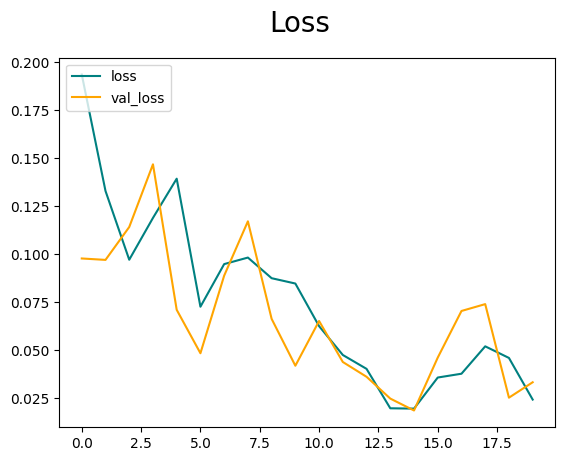

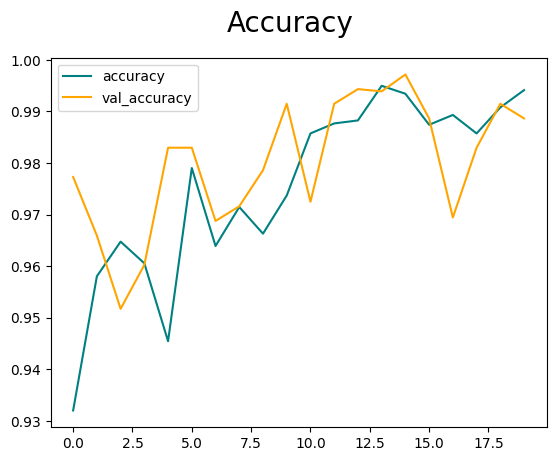

In [87]:
# Loss visualization
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


# Accuracy visualization
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 4. Evaluation of the model performance 

In [96]:
# Evaluate the model on the test dataset / batches

eval_loss, eval_accuracy = model.evaluate(test)
print("Our model shows a testing accuracy of {}% with {} loss.".format(eval_accuracy, eval_loss))

6/6 [==============================] - 7s 281ms/step - loss: 0.0188 - accuracy: 0.9948
Our model shows a testing accuracy of 0.9947916865348816% with 0.01884116418659687 loss.


In [97]:
# Let's also observe the classification report and the confusion matrix by predicting the test dataset
pre = Precision()
rec = Recall()
Y = []
Y_pred = []
for batch in test.as_numpy_iterator():
    X,y = batch
    y_pred = model.predict(X)

    # Since the output comes as softmax layer, so we need to transform it back to classes
    y_pred = np.argmax(y_pred, axis= 1)
    Y_pred.extend(y_pred)
    Y.extend(y)

    pre.update_state(y, y_pred)
    rec.update_state(y, y_pred)

print('Precision: {}, Recall: {}'.format(pre.result().numpy(), rec.result().numpy()))

1/1 [==============================] - 0s 206ms/step
Precision: 1.0, Recall: 1.0


In [98]:
# Lets also build a report also assessing the classification performance
target_names = [classes[i] for i in range(4)]

cr = classification_report(Y, Y_pred, target_names= target_names)
print(cr)

                                 precision    recall  f1-score   support

Cardboard Waste (Biodegradable)       1.00      1.00      1.00        44
     Food Waste (Biodegradable)       1.00      1.00      1.00        54
Glass Waste (Non-Biodegradable)       1.00      0.98      0.99        51
Metal Waste (Non-Biodegradable)       0.98      1.00      0.99        43

                       accuracy                           0.99       192
                      macro avg       0.99      1.00      0.99       192
                   weighted avg       0.99      0.99      0.99       192



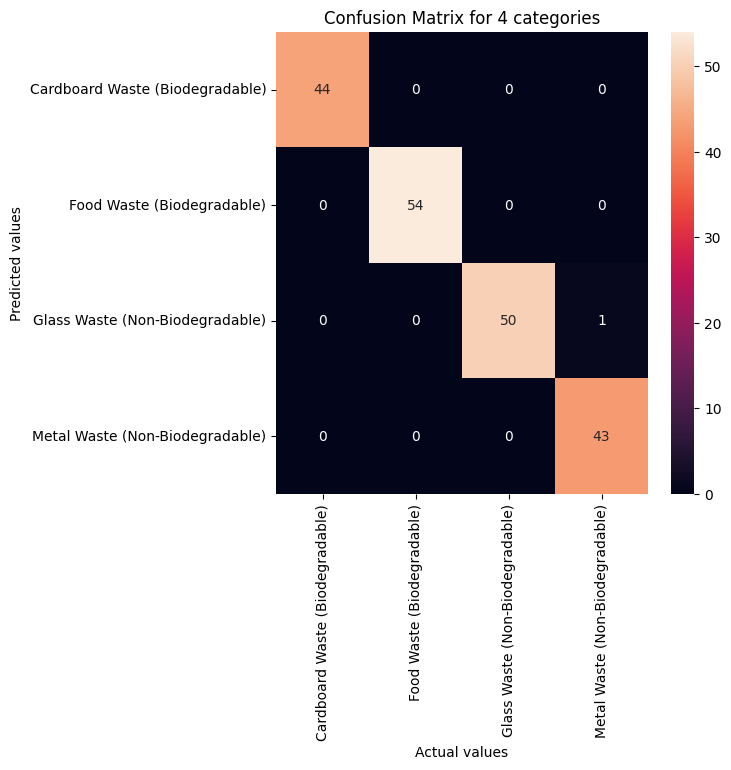

In [99]:
# Get the confusion matrix as well
cm = confusion_matrix(Y, Y_pred)
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)

plt.figure(figsize=(6,6))
sns.heatmap(cm_df,annot= True)
plt.title("Confusion Matrix for 4 categories")
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()


# Save the model

In [ ]:
# Save the model
os.mkdir('Model')
model.save(os.path.join('Model', 'garbage_classifier.h5'))

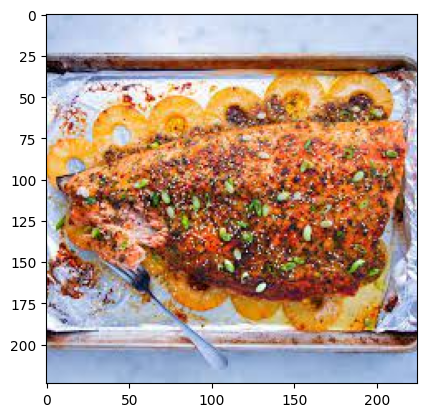

1/1 [==============================] - 0s 80ms/step
Predicted class for the image is: Food Waste (Biodegradable)


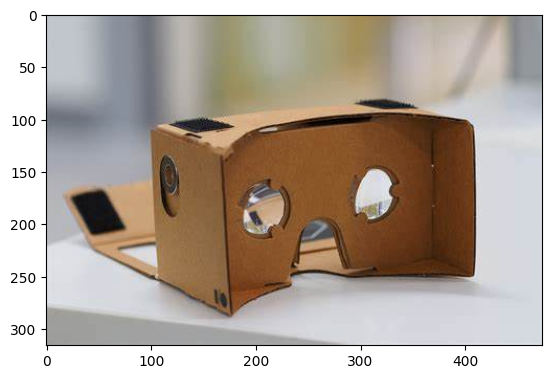

1/1 [==============================] - 0s 35ms/step
Predicted class for the image is: Cardboard Waste (Biodegradable)


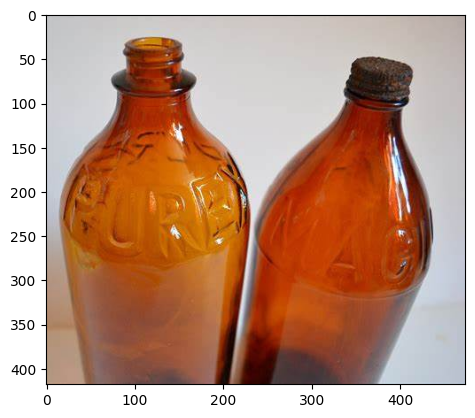

1/1 [==============================] - 0s 35ms/step
Predicted class for the image is: Metal Waste (Non-Biodegradable)


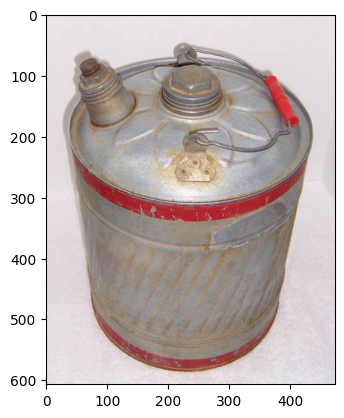

1/1 [==============================] - 0s 34ms/step
Predicted class for the image is: Metal Waste (Non-Biodegradable)


In [104]:
# Once we have saved the model, we can load it again and test for new images
image_classifier_model = load_model(os.path.join('Model', 'garbage_classifier.h5'))
test_cases = ["test_image_1.jpeg", "test_image_2.jpeg", "test_image_3.jpeg", "test_image_4.jpeg"]

def classify_image(img, model, classes):

    """
    Utility function to classify image using model
    """
    # read the image
    img = cv2.imread(img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

    # resize the image to the required dimensions
    resized_img = tf.image.resize(img, (256,256))
    
    # since the model inputs from a batch, so we convert a single image into a batch of single image
    resized_img = np.expand_dims(resized_img/255, 0)
    # predict the image using model
    yhat = model.predict(resized_img)
    print("Predicted class for the image is: {}".format(classes[np.argmax(yhat,axis=1)[0]]))

for i in test_cases:
    classify_image(os.path.join('test_cases',i), image_classifier_model,classes)